In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from itertools import chain
from ddeint import ddeint
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid

sns.set_theme(style="darkgrid")

# Working with Delayed Differential Equations to Obtain Canard-like Behavior

Originally, our approach was to look for canard behavior from Networks of Neurons. We wanted to specifically look at using networks of FHN neurons.

The more reading we did, we found that systems of FHN neurons have somewhat uninteresting results and take a lot of time to work with.

Although networks of neurons were a dead end, at least for our project, we found that there was a simplification of networks where we just simulate one neuron with modeled synaptic behavior instead of an applied current term.

This new direction proved to be more interesting, and the results are shown here.

In [ ]:
"""
CODE FROM FH_N.ipynb FOR REFERENCE
"""

def FH_N(t, y, a=5, tau_n=60, I=-4.2):
    v, n = y
    dvdt = v - (v**3) / 3 - n + I
    dndt = (a * v - n) / tau_n

    return np.array([dvdt, dndt])

In [2]:
def delayed_fhn(Y,t,d:float, g_c:float = 0.25, u_syn:float = 0.8, a:float = 0.7, b:float = 0.8, c:float = 3):
    y_now = Y(t)
    y_delay = Y(t-d)

    u,v = y_now
    u_delay,_ = y_delay

    dudt = u - 1/3*u**3 + v + g_c * np.tanh(u_delay - u_syn)
    dvdt = ( -u + a - b*v )/c

    return [dudt, dvdt]

# This was strange formatting for code that we had used earlier on, it's almost identical to the code above
# def initialize_delayed_fhn(d:float, g_c:float = 0.25, u_syn:float = 0.8, a:float = 0.7, b:float = 0.8, c:float = 3):
#     def delayed_fhn(Y,t):
#         y_now = Y(t)
#         y_delay = Y(t-d)

#         u,v = y_now
#         u_delay,_ = y_delay

#         dudt = u - 1/3*u**3 + v + g_c * np.tanh(u_delay - u_syn)
#         dvdt = ( -u + a - b*v )/c

#         return [dudt, dvdt]
#     return delayed_fhn

In [4]:
# Test Parameters
a = 0.7
b = 0.8
c = 3.0
tau = 100
g_c = 0.8
u_syn = 0.0

# Setting up time mesh
dt = 0.01
T = 300
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

# Setting History Function
def history(t):
    return [0.1, 0]

# Solving DDE Numerically
first_delayed_fhn = lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c)
soln = ddeint(first_delayed_fhn, g=history, tt=t_span )

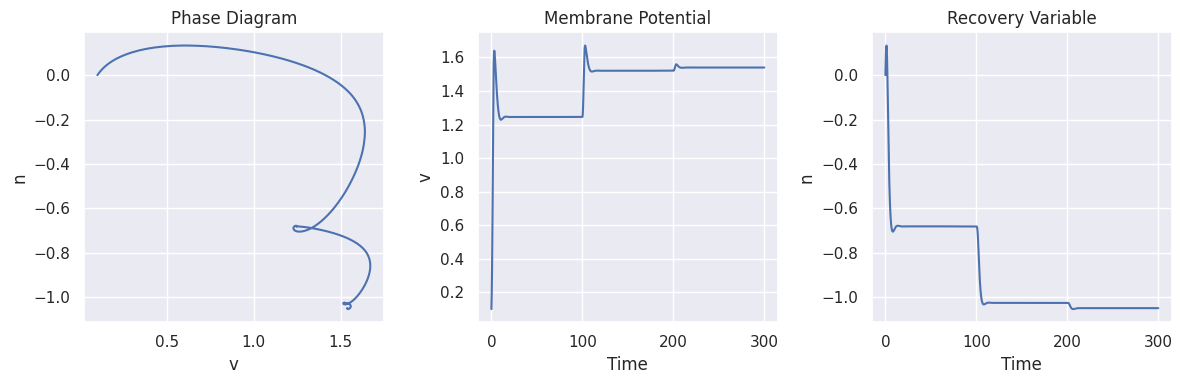

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(soln[:,0], soln[:,1])
plt.xlabel('v')
plt.ylabel('n')
plt.title('Phase Diagram')

plt.subplot(1, 3, 2)
plt.plot(t_span, soln[:,0])
plt.xlabel('Time')
plt.ylabel('v')
plt.title('Membrane Potential')

plt.subplot(1, 3, 3)
plt.plot(t_span, soln[:,1])
plt.xlabel('Time')
plt.ylabel('n')
plt.title('Recovery Variable')

plt.tight_layout()
plt.show()

## Varying Specific Parameters in the DDE Model with Constant History Functions

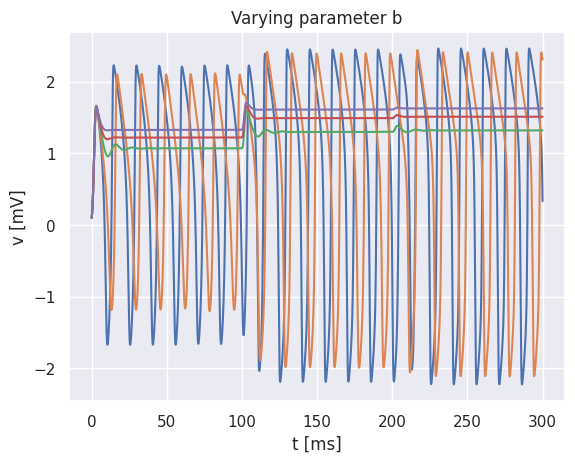

In [ ]:
# Test Parameters
a = 0.7
# b = 0.8
c = 3.0
tau = 100
g_c = 0.8
u_syn = 0.0

# Typical b value was 0.8
b_vals = np.linspace(0,1,5)

# Setting History Function
def history(t):
    return [0.1, 0]

# Setting up time mesh
dt = 0.01
T = 300
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

for b in b_vals:
    soln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

    plt.plot(t_span, soln[:,0])

plt.title('Varying parameter b')
plt.ylabel('v [mV]')
plt.xlabel('t [ms]')
plt.show()

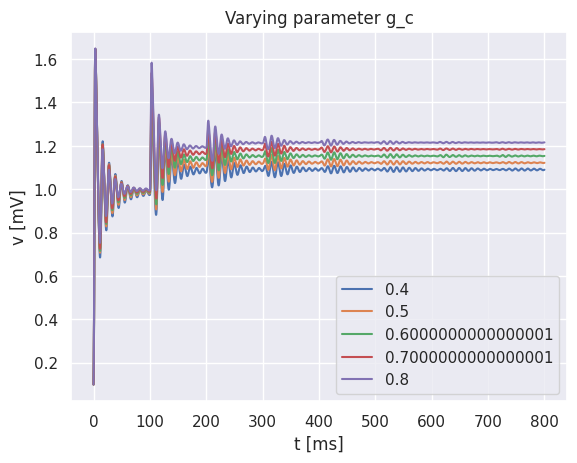

In [ ]:
# Test Parameters
a = 0.7
b = 0.4
c = 3.0
tau = 100
# g_c = 0.8
u_syn = 0.0

# Typical g_c value was 0.8
gc_vals = np.linspace(0.4,0.8,5)

# Setting History Function
def history(t):
    return [0.1, 0]

# Setting up time mesh
dt = 0.01
T = 800
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

for g_c in gc_vals:
    soln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

    plt.plot(t_span, soln[:,0])

plt.title('Varying parameter g_c')
plt.ylabel('v [mV]')
plt.xlabel('t [ms]')
plt.legend(gc_vals)
plt.show()

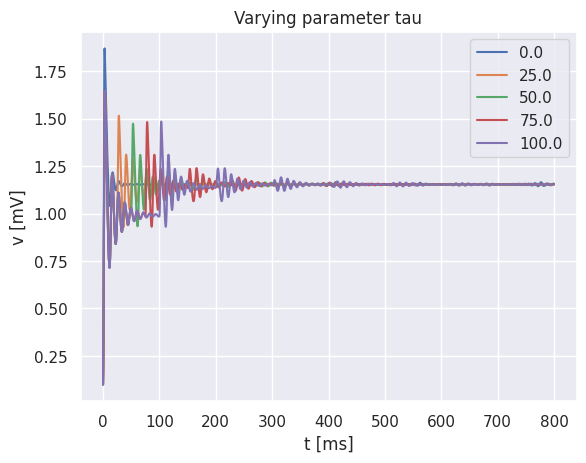

In [ ]:
# Test Parameters
a = 0.7
b = 0.4
c = 3.0
# tau = 100
g_c = 0.6
u_syn = 0.0

# Typical tau value was 100
delay_vals = np.linspace(0,100,5)

# Setting History Function
def history(t):
    return [0.1, 0]

# Setting up time mesh
dt = 0.01
T = 800
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

for tau in delay_vals:
    soln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

    plt.plot(t_span, soln[:,0])

plt.title('Varying parameter tau')
plt.ylabel('v [mV]')
plt.xlabel('t [ms]')
plt.legend(delay_vals)
plt.show()

## Trying to Mimic the MMO Plot from Previous Research

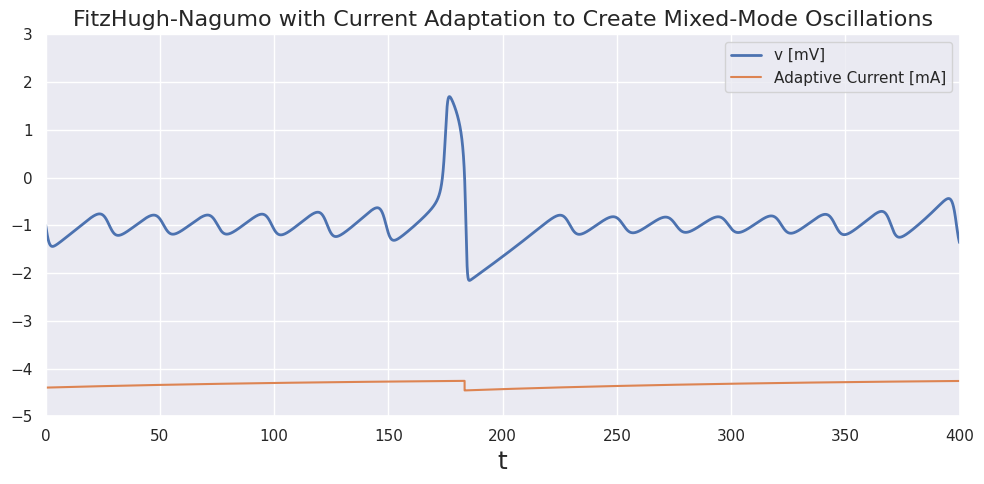

In [11]:
"""
CODE TAKEN FROM MMO.ipynb
JUST TO SET THE HISTORY FUNCTION
"""

# Parameters
a = 5
tau_n = 60
I_ext = -4.2
tau_adapt = 150
delta = 0.2

# Time setup
t_final = 400
dt = 0.01
dt05 = dt / 2
m_steps = round(t_final / dt)
t = np.linspace(0, t_final, m_steps + 1)

# dt = 0.01
# T = 400
# steps = int(T / dt)
# t_span = np.linspace(0, T, steps)

# Initialize variables
v = np.zeros(m_steps + 1)
n = np.zeros(m_steps + 1)
I_adapt = -delta

# Initial conditions
v[0] = -1
n[0] = -4.75

I_adapt_list = []

# Integration loop
for k in range(m_steps):
    # First half-step
    v_inc = v[k] - v[k]**3 / 3 - n[k] + I_ext + I_adapt
    n_inc = (a * v[k] - n[k]) / tau_n
    v_tmp = v[k] + dt05 * v_inc
    n_tmp = n[k] + dt05 * n_inc

    # Second half-step
    I_adapt_half = I_adapt * np.exp(-dt05 / tau_adapt)
    v_inc = v_tmp - v_tmp**3 / 3 - n_tmp + I_ext + I_adapt_half
    n_inc = (a * v_tmp - n_tmp) / tau_n

    # Full update
    v[k + 1] = v[k] + dt * v_inc
    n[k + 1] = n[k] + dt * n_inc
    I_adapt = I_adapt * np.exp(-dt / tau_adapt)

    # Spike detection and adaptation jump
    if v[k + 1] < 0 and v[k] >= 0:
        I_adapt -= delta
    
    I_adapt_list.append(I_adapt)

I_adapt_list = np.array(I_adapt_list)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, v, linewidth=2)
plt.plot(t[1:],I_adapt_list - 4.2)
plt.xlabel('t', fontsize=18)
plt.legend(["v [mV]","Adaptive Current [mA]"])
plt.title('FitzHugh-Nagumo with Current Adaptation to Create Mixed-Mode Oscillations', fontsize=16)
plt.grid(True)
plt.ylim([-5, 3])
plt.xlim([0, t_final])
plt.tight_layout()
plt.show()
# plt.savefig("../assets/MMO_Canard.png", dpi=300)

historyFuncV = CubicSpline(t,v)

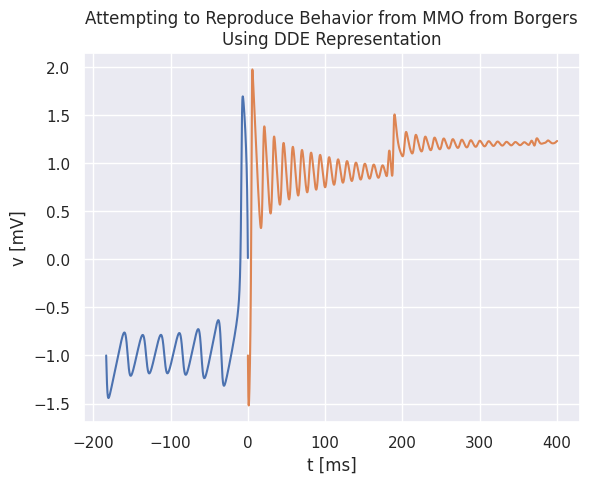

In [ ]:
# Test Parameters
a = 0.7
b = 0.6
c = 3.0
tau = 183.35    # Based on the time of the MMO
g_c = 0.3
u_syn = 0.0

# Setting History Function
def history(t):
    return [historyFuncV(t), 0]

# Setting up time mesh
dt = 0.01
T = 400
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

soln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

delay_time = t_span[ t_span <= tau ]

plt.plot(delay_time - tau, historyFuncV(delay_time))
plt.plot(t_span, soln[:,0])
plt.title('Attempting to Reproduce Behavior from MMO from Borgers\nUsing DDE Representation')
plt.ylabel('v [mV]')
plt.xlabel('t [ms]')
plt.show()

### Working to Optimize Parameters to Find Parameters that Match the MMO Function

In [ ]:
def loss(params):
    a,b,g_c = params

    # Setting up time mesh
    dt = 0.01
    T = 400
    steps = int(T / dt)
    t_span = np.linspace(0, T, steps)

    # a = 0.7
    c = 3.0
    tau = 183.35    # Based on the time of the MMO
    u_syn = 0.0
    
    approxSoln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

    integral = trapezoid(np.power(v[1::] - approxSoln[:,0],2))

    return np.sqrt( integral )

# loss([0.1,0.1])

In [14]:
initial_guess = [0.7,0.9,0.3]
result = minimize(loss, initial_guess)

best_a,best_b, best_gc = result.x

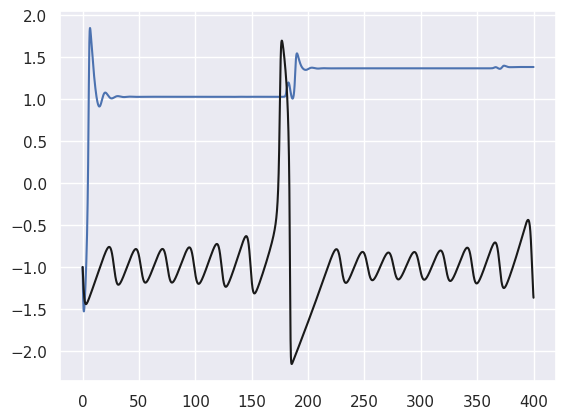

In [ ]:
# Setting up time mesh
dt = 0.01
T = 400
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

a = 0.7
c = 3.0
tau = 183.35    # Based on the time of the MMO
u_syn = 0.0

approxSoln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=best_gc,d=tau,a=best_a,b=best_b,c=c), g=history, tt=t_span )

plt.plot(t_span, approxSoln[:,0])
plt.plot(t_span, historyFuncV(t_span), 'k')
plt.show()

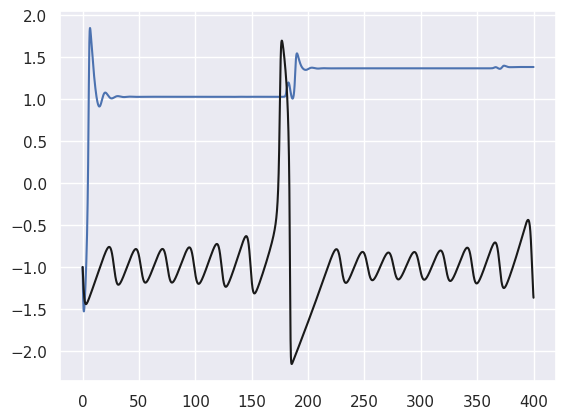

In [16]:
plt.plot(t_span, approxSoln[:,0])
plt.plot(t_span, historyFuncV(t_span), 'k')
plt.show()

### Optimizing Just g_c

A lot of time is spent on optimizing multiple parameters, so I would like to see how one parameter does

In [ ]:
def gc_loss(g_c):
    g_c = g_c[0]

    # Setting up time mesh
    dt = 0.01
    T = 400
    steps = int(T / dt)
    t_span = np.linspace(0, T, steps)

    a = 0.7
    b = 0.8
    c = 3.0
    tau = 183.35    # Based on the time of the MMO
    u_syn = 0.0
    
    approxSoln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

    integral = trapezoid(np.power(v[1::] - approxSoln[:,0],2))

    return np.sqrt( integral )

# loss([0.1,0.1])

In [18]:
initial_gc = [0.65]
result = minimize(gc_loss, initial_gc)

best_gc = result.x[0]
print(best_gc)

5.683389079125342


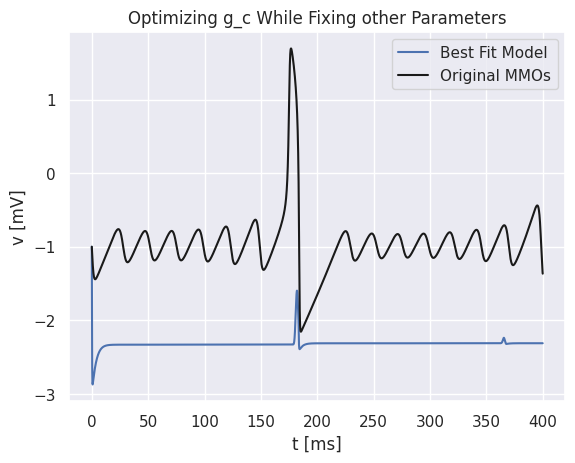

In [ ]:
# Setting up time mesh
dt = 0.01
T = 400
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

a = 0.7
b = 0.8
c = 3.0
tau = 183.35    # Based on the time of the MMO
u_syn = 0.0

approxSoln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=best_gc,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

plt.plot(t_span, approxSoln[:,0],label="Best Fit Model")
plt.plot(t_span, historyFuncV(t_span), 'k', label="Original MMOs")

plt.legend()
plt.title('Optimizing g_c While Fixing other Parameters')
plt.xlabel('t [ms]')
plt.ylabel('v [mV]')

plt.show()

### Optimizing b While Fixing Other Parameters

In [ ]:
def b_loss(b):
    b = b[0]

    # Setting up time mesh
    dt = 0.01
    T = 400
    steps = int(T / dt)
    t_span = np.linspace(0, T, steps)

    g_c = 0.65
    a = 0.7
    # b = 0.8
    c = 3.0
    tau = 183.35    # Based on the time of the MMO
    u_syn = 0.0
    
    approxSoln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=b,c=c), g=history, tt=t_span )

    integral = trapezoid(np.power(v[1::] - approxSoln[:,0],2))

    return np.sqrt( integral )


In [21]:
initial_b = [0.8]
result = minimize(b_loss, initial_b)

best_b = result.x[0]
print(best_b)

0.8


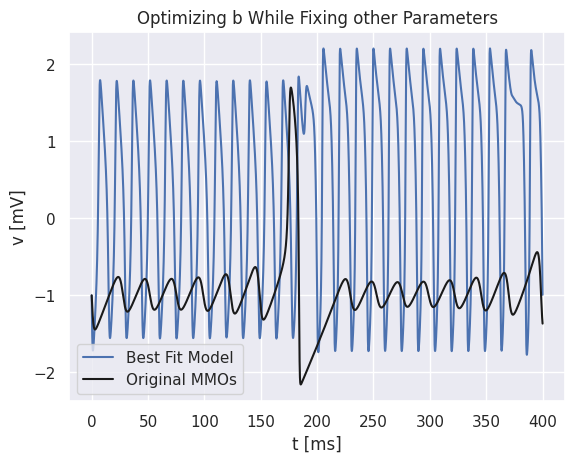

In [ ]:
# Setting up time mesh
dt = 0.01
T = 400
steps = int(T / dt)
t_span = np.linspace(0, T, steps)

g_c = 0.65
a = 0.7
# b = 0.8
c = 3.0
tau = 183.35    # Based on the time of the MMO
u_syn = 0.0

approxSoln = ddeint(lambda Y,t: delayed_fhn(Y,t,u_syn=u_syn,g_c=g_c,d=tau,a=a,b=best_b,c=c), g=history, tt=t_span )

plt.plot(t_span, approxSoln[:,0],label="Best Fit Model")
plt.plot(t_span, historyFuncV(t_span), 'k', label="Original MMOs")

plt.legend()
plt.title('Optimizing b While Fixing other Parameters')
plt.xlabel('t [ms]')
plt.ylabel('v [mV]')

plt.show()

# References

[1] S. Gao, J. Shen, and X. Hu, “Dynamics of delayed and diffusive FitzHugh–Nagumo network,” Eur. Phys. J. Spec. Top., Apr. 2024, doi: 10.1140/epjs/s11734-024-01193-4.